# Data Preparation for Synthetic Handwritten Text Data Generation

## Utilities

In [1]:
import os
import numpy as np
import xml.etree.ElementTree as ET
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
MAX_NUM = 100000
CONST_DELTA = 100
def extract_strokes(filepath):
    """
    Method to parse XML and extract point locations (x,y)
    Parameters:
        @filepath: location of the IAM XML to be parsed
    Returns:
        List of points
    """
    xml_tree = ET.parse(filepath)
    root_node = xml_tree.getroot()

    point_list = []

    x_offset = MAX_NUM
    y_offset = MAX_NUM
    #y_height = 0
    
    for i in range(1, 4):
        x_offset = min(x_offset, float(root_node[0][i].attrib['x']))
        y_offset = min(y_offset, float(root_node[0][i].attrib['y']))
        #y_height = max(y_height, float(root_node[0][i].attrib['y']))
        
    #y_height -= y_offset
    x_offset -= CONST_DELTA
    y_offset -= CONST_DELTA

    for stroke in root_node[1].findall('Stroke'):
        points = []
        for point in stroke.findall('Point'):
            points.append([float(point.attrib['x'])-x_offset,float(point.attrib['y'])-y_offset])
        point_list.append(points)
    return point_list

In [3]:
def convert_to_coordinates(point_list):
    """
    Method to convert (x,y) points to coordinates with offsets
    Parameters:
        @point_list: List of points from XML
    Returns:
        A numpy array of coordinates in offset format
    """
    X=0
    Y=1
    EOS=2
    
    np_dim = sum([len(i) for i in point_list])
    stroke_coordinates = np.zeros((np_dim, 3), dtype=np.int16)

    prev_x = 0
    prev_y = 0
    counter = 0
    for stroke in point_list:
        for idx,point in enumerate(stroke):
            stroke_coordinates[counter,X] = int(point[0]) - prev_x
            stroke_coordinates[counter,Y] = int(point[1]) - prev_y
            prev_x = int(point[0])
            prev_y = int(point[1])
            stroke_coordinates[counter, EOS] = 0
            
            # end of stroke
            if (idx == (len(stroke)-1)): 
                stroke_coordinates[counter, EOS] = 1
            counter += 1
    return stroke_coordinates

In [4]:
def line_plot(stroke_coordinates):
    """
    Method to plot strokes using matplotlib
    Parameters:
        stroke_coordinates: Offset adjusted coordinates
    Returns:
        None
    """
    # identify end of stroke points
    eos_preds = np.where(stroke_coordinates[:,-1] == 1)
    
    #add start and end indices
    eos_preds = [0] + list(eos_preds[0]) + [-1] 
    
    plt.figure(figsize=(20,2))
    for i in range(len(eos_preds)-1):
        start = eos_preds[i]+1
        stop = eos_preds[i+1]
        
        # pass color param to print in single color
        # negate y-coordinates to match matplotlib and whiteboard space
        plt.plot(stroke_coordinates[start:stop,0], 
                 -stroke_coordinates[start:stop,1],
                 linewidth=2.0)
    plt.show()

## Load Data

In [5]:
point_list = extract_strokes('a01-000u-01.xml')

## Prepare Data

In [6]:
stroke_coords = convert_to_coordinates(point_list)

In [7]:
strokes = stroke_coords.copy()
strokes[:,:-1] = np.cumsum(stroke_coords[:,:-1], axis=0)

## Plot Results

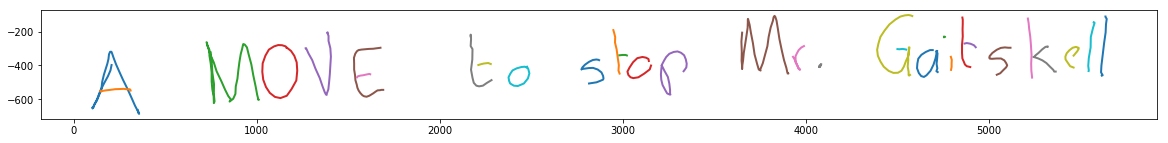

In [8]:
line_plot(strokes)

## Sample Data

In [9]:
# extracted x,y coordinates from XML
point_list[0][:5]

[[207.0, 371.0],
 [206.0, 398.0],
 [200.0, 430.0],
 [186.0, 465.0],
 [164.0, 509.0]]

In [10]:
# transformed into numpy array as offsets
stroke_coords

array([[207, 371,   0],
       [ -1,  27,   0],
       [ -6,  32,   0],
       ...,
       [  9,  17,   0],
       [ -5,   2,   0],
       [  3,   4,   1]], dtype=int16)

In [11]:
# same as original with eos for plotting
strokes

array([[ 207,  371,    0],
       [ 206,  398,    0],
       [ 200,  430,    0],
       ...,
       [5624,  459,    0],
       [5619,  461,    0],
       [5622,  465,    1]], dtype=int16)